In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input,GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # for the progress bar
from google.colab import drive
import zipfile

In [3]:
# mounting google drive
drive.mount('/content/drive')

# path to the zip file
zip_path = '/content/drive/MyDrive/archive (6).zip'
extract_path = '/content/UTKFace'

# extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def load_images_from_folder(folder, img_size=(128, 128)):
    images = [] #empty list to append the data to them
    ages = []

    # listing all the files in the folder
    file_list = os.listdir(folder)

    for img_name in tqdm(file_list):  #for progress bar
        age = int(img_name.split("_")[0]) # since the age is the data we need spliting it from the first index by delimeter
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path) #reading the image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #RGB 3 chanels
        img = cv2.resize(img, img_size) #resizing the image 128 , 128
        img = img / 255.0  # Scaling the images in a range 0 and 1
        images.append(img) #appending it to the empty list of the images list
        ages.append(age) # same for the age

    return np.array(images), np.array(ages) # returning them as numpy array [matrix of scaled image]

In [5]:
# Path to the extracted folder
folder_path = '/content/UTKFace/utkface_aligned_cropped/UTKFace'

# Load images and ages
images, ages = load_images_from_folder(folder_path)

100%|██████████| 23708/23708 [00:19<00:00, 1204.10it/s]


In [6]:
 #spliting the dataset into train and test
x_train, x_test, y_train, y_test = train_test_split(images, ages, test_size=0.15, random_state=42)

In [ ]:
x_train[1]

array([[[0.32941176, 0.30980392, 0.37647059],
        [0.29803922, 0.27843137, 0.34117647],
        [0.25490196, 0.23921569, 0.29803922],
        ...,
        [0.1372549 , 0.16078431, 0.05098039],
        [0.15294118, 0.17647059, 0.06666667],
        [0.16078431, 0.19607843, 0.0745098 ]],

       [[0.29411765, 0.27843137, 0.3372549 ],
        [0.2627451 , 0.24705882, 0.30588235],
        [0.21960784, 0.2       , 0.2627451 ],
        ...,
        [0.1372549 , 0.16078431, 0.05490196],
        [0.14509804, 0.16862745, 0.05882353],
        [0.15294118, 0.18823529, 0.07058824]],

       [[0.26666667, 0.25098039, 0.30980392],
        [0.23529412, 0.21960784, 0.27843137],
        [0.19215686, 0.17647059, 0.23529412],
        ...,
        [0.14901961, 0.17254902, 0.06666667],
        [0.14901961, 0.17647059, 0.07058824],
        [0.14901961, 0.18431373, 0.0745098 ]],

       ...,

       [[0.08235294, 0.07058824, 0.09411765],
        [0.08235294, 0.0745098 , 0.09411765],
        [0.07843137, 0

In [ ]:
x_test[1]

array([[[0.16078431, 0.14117647, 0.11764706],
        [0.1372549 , 0.11764706, 0.09411765],
        [0.12156863, 0.10196078, 0.08235294],
        ...,
        [0.14901961, 0.1372549 , 0.11764706],
        [0.11372549, 0.10196078, 0.08235294],
        [0.08627451, 0.0745098 , 0.05490196]],

       [[0.16862745, 0.14901961, 0.1254902 ],
        [0.14117647, 0.12156863, 0.09803922],
        [0.1254902 , 0.10588235, 0.08235294],
        ...,
        [0.16078431, 0.14901961, 0.12941176],
        [0.12941176, 0.11764706, 0.09803922],
        [0.10588235, 0.09411765, 0.0745098 ]],

       [[0.16862745, 0.14901961, 0.1254902 ],
        [0.14901961, 0.12941176, 0.10588235],
        [0.13333333, 0.10980392, 0.08627451],
        ...,
        [0.17254902, 0.16078431, 0.14117647],
        [0.14117647, 0.12941176, 0.10980392],
        [0.11764706, 0.10588235, 0.08627451]],

       ...,

       [[0.36862745, 0.21960784, 0.10588235],
        [0.34509804, 0.19607843, 0.08235294],
        [0.33333333, 0

In [7]:
x_train.shape

(20151, 128, 128, 3)

In [ ]:
x_test.shape

(3557, 150, 150, 3)

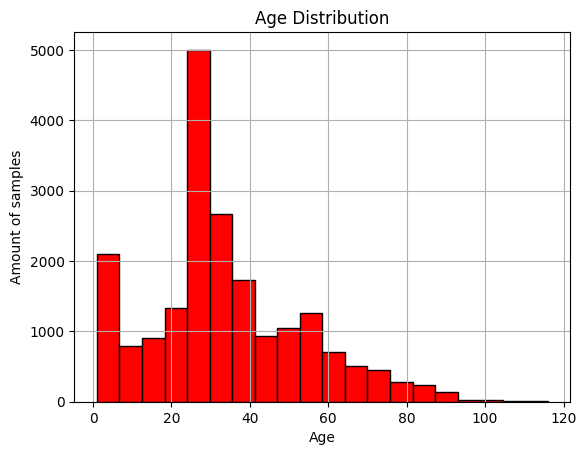

In [ ]:
#the age distribution
plt.hist(y_train, bins=20, color='red', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Amount of samples')
plt.grid(True)
plt.show()

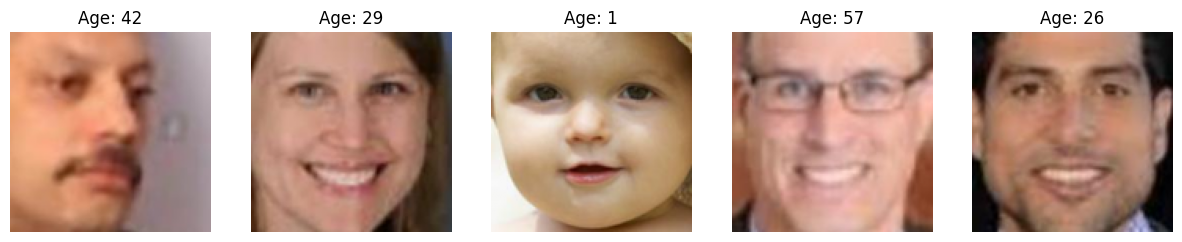

In [8]:
#a function to display images with their corresponding ages
def show_samples(images, ages, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
    for i in range(num_samples):
        axes[i].imshow(images[i])
        axes[i].set_title("Age: {}".format(ages[i]))
        axes[i].axis('off')
    plt.show()

# show some samples from the training set using the function created
show_samples(x_train, y_train)

In [17]:
from keras.applications import ResNet101

base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of ResNet101 model
for layer in base_model.layers:
    layer.trainable = False

171446536/171446536 [==============================] - 9s 0us/step


In [18]:
# Create the model
age_model = Sequential()
age_model.add(base_model)

# Adding custom layers on top of Xception
age_model.add(GlobalAveragePooling2D())
age_model.add(Dense(512, activation='relu'))
age_model.add(Dropout(0.5))
age_model.add(Dense(256, activation='relu'))
age_model.add(Dropout(0.5))
age_model.add(Dense(1, activation='relu', name='age'))

In [19]:
from keras.optimizers import Adam
age_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mae', metrics=['mae'])

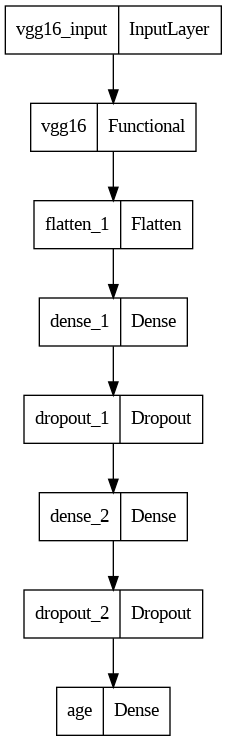

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(age_model)

In [12]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# call back function to stop the training once the model is over fitting when the val_loss after patience of 5 epochs will stop the training
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [20]:
#training the model

history_age = age_model.fit(x_train , y_train, validation_data=(x_test, y_test), epochs=50 , shuffle = True, batch_size = 32,callbacks=[early_stop])

Epoch 1/50
630/630 [==============================] - 52s 71ms/step - loss: 17.4251 - mae: 17.4251 - val_loss: 14.6858 - val_mae: 14.6858
Epoch 2/50
630/630 [==============================] - 41s 65ms/step - loss: 15.3371 - mae: 15.3371 - val_loss: 14.7002 - val_mae: 14.7002
Epoch 3/50
630/630 [==============================] - 41s 65ms/step - loss: 15.3179 - mae: 15.3179 - val_loss: 14.6326 - val_mae: 14.6326
Epoch 4/50
630/630 [==============================] - 41s 65ms/step - loss: 15.3002 - mae: 15.3002 - val_loss: 14.5925 - val_mae: 14.5925
Epoch 5/50
630/630 [==============================] - 41s 65ms/step - loss: 15.2059 - mae: 15.2059 - val_loss: 14.5557 - val_mae: 14.5557
Epoch 6/50
630/630 [==============================] - 41s 65ms/step - loss: 15.1572 - mae: 15.1572 - val_loss: 14.5173 - val_mae: 14.5173
Epoch 7/50
630/630 [==============================] - 41s 65ms/step - loss: 15.1458 - mae: 15.1458 - val_loss: 14.4767 - val_mae: 14.4767
Epoch 8/50
630/630 [==============

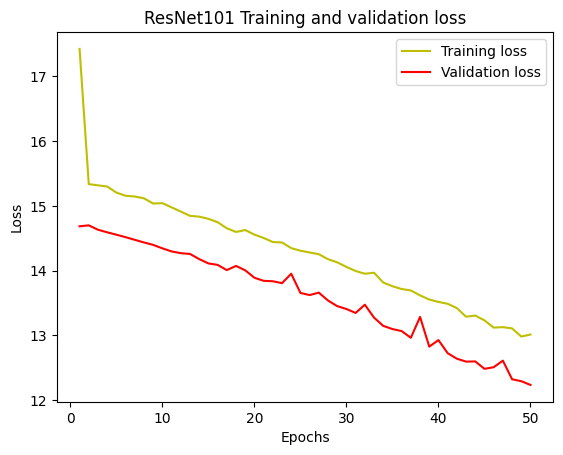

In [21]:
import matplotlib.pyplot as plt
# Plot the training and validation loss
loss = history_age.history['loss']
val_loss = history_age.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('ResNet101 Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
test_loss, test_mae = age_model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

112/112 [==============================] - 6s 57ms/step - loss: 12.2355 - mae: 12.2355
Test Loss: 12.235481262207031
Test MAE: 12.235481262207031


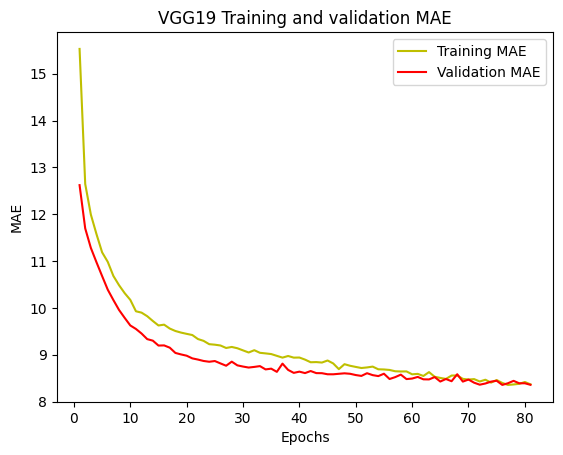

In [16]:
# Plot the training and validation MAE
mae = history_age.history['mae']
val_mae = history_age.history['val_mae']
epochs = range(1, len(mae) + 1)

plt.plot(epochs, mae, 'y', label='Training MAE')
plt.plot(epochs, val_mae, 'r', label='Validation MAE')
plt.title('VGG19 Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()